In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
##迭代器################################

from tensorflow.compat.v1 import keras

from __future__ import print_function

import numpy as np 
import os
import skimage.io as io
import matplotlib.pyplot as plt

import skimage.transform as trans

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.compat.v1.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, UpSampling2D

IMG_SIZE = 224
IMG_BANDS = 3
# =============================================================================
# ##这一步获取了原图和mask
def trainGenerator(batch_size,train_path,train_path2,image_folder,mask_folder,aug_dict,
                    flag_multi_class, num_class ,image_color_mode = 'rgb',#"grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",save_to_dir = None,target_size = (IMG_SIZE,IMG_SIZE),seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    print(image_generator)
    mask_generator = mask_datagen.flow_from_directory(
        train_path2,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    new_mask = np.ones([batch_size,224,224,2])
    for (img,mask) in train_generator:
        #img = img / 255
        #print('mask',mask.shape)
        img,mask = adjustData(img,mask,
                           flag_multi_class,   ##参数（flag_multi_class）用来开启多分类
                           num_class,new_mask)##这里对图像进行了处理，用以减小计算量（函数定义在下面）
        yield (img,mask)##用生成器进行迭代数据，可以传入model.fit_generator（）这个函数进行训练
        new_mask = np.ones([batch_size,224,224,2])
#    return img, mask

def adjustData(img,mask,flag_multi_class,num_class,new_mask):
    if (flag_multi_class):#如果多分类，在mask添加多层，每层对应一个类别
        img = img / 255
    return (img,mask)


# =============================================================================


In [4]:
img_path = '/content/drive/MyDrive/2105Dinghu/data/v2/train/'
mask_path = '/content/drive/MyDrive/2105Dinghu/data/v2/train/'
img_files = 'image_crop'
mask_files = 'mask_crop'
num_class = {'0','1'}


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,img_path,         #图像路径
                            mask_path,    #mask路径
                            img_files,      #mask文件夹名称
                            mask_files,     #图像文件夹名称（不懂的话看此函数定义和keras文档）
                            data_gen_args,True,#
                            num_class,target_size=(IMG_SIZE,IMG_SIZE))

img_valid_path = '/content/drive/MyDrive/2105Dinghu/data/v2/valid/'
mask_valid_path = '/content/drive/MyDrive/2105Dinghu/data/v2/valid/'
valid_img_files = 'image_crop'
valid_mask_files = 'mask_crop'
valid_data = trainGenerator(2,img_valid_path,         #图像路径
                            mask_valid_path,    #mask路径
                            valid_img_files,      #mask文件夹名称
                            valid_mask_files,     #图像文件夹名称（不懂的话看此函数定义和keras文档）
                            data_gen_args,True,#
                            num_class,target_size=(IMG_SIZE,IMG_SIZE))

In [ ]:
# with max pooling
TARGET_SIZE = 224
BANDS = 3
def unet(pretrained_weights = None,input_size = (TARGET_SIZE, TARGET_SIZE, BANDS)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = Conv2D(512, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.7)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #===================================================#

    conv5 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(drop5)
    
    #conv5_2 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    #conv5_2 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5_2)
    #drop5_2 = Dropout(0.5)(conv5_2)
    #pool5_2 = MaxPooling2D(pool_size=(2, 2))(drop5_2)

    #up6_2 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool5_2))
    #merge6_2 = concatenate([drop5_2,up6_2],)
    #conv6_2 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6_2)
    #conv6_2 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6_2)
    
    up6 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge6 = concatenate([drop5,up6],)
    conv6 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(1024, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
     #===================================================#
    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
    merge7 = concatenate([conv4,up7],)
    conv7 = Conv2D(512, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(512, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv3,up8], axis = 3)
    conv8 = Conv2D(256, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(256, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv2,up9], axis = 3)
    conv9 = Conv2D(128, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(128, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    up10 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv1,up10], axis = 3)
    conv10 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    
    #up11 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv10))
    #merge11 = concatenate([conv1,up11], axis = 3)
    #conv11 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11)
    #conv11 = Conv2D(64, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv11 = Conv2D(8, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    conv12 = Conv2D(1, 1, activation = 'sigmoid', name = 'result')(conv11) ##注意output层
                                                         
    model = Model(inputs = inputs, outputs = conv12)

    model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy']) #Adam(lr = 1e-5)
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
# =============================================================================
model = unet()
#model_checkpoint = ModelCheckpoint('saver\module_1.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 224, 224, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_112[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_113[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#存储loss和acc
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        #plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            #plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Found 39 images belonging to 1 classes.
Found 39 images belonging to 1 classes.
Epoch 1/500
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 2.0000 - loss: 0.6296 - accuracy: 0.7104Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


10/10 [==============================] - 15s 1s/step - batch: 4.5000 - size: 2.0000 - loss: 0.6296 - accuracy: 0.7104 - val_loss: 0.5684 - val_accuracy: 0.7468
Epoch 2/500
10/10 [==============================] - 6s 601ms/step - batch: 4.5000 - size: 1.9000 - loss: 0.5705 - accuracy: 0.7194 - val_loss: 0.4909 - val_accuracy: 0.7928
Epoch 3/500
10/10 [==============================] - 5s 470ms/step - batch: 4.5000 - size: 2.0000 - loss: 0.5014 - accuracy: 0.7707 - val_loss: 0.4258 - val_accuracy: 0.7975
Epoch 4/500
10/10 [==============================] - 4s 456ms/step - batch: 4.5000 - size: 1.9000 - loss: 0.4265 - accuracy: 0.7944 - val_loss: 0.3954 - val_accuracy: 0.7888
Epoch 5/500
10/10 [==============================] - 5s 472ms/step - batch: 4.5000 - size: 2.0000 - loss: 0.4230 - accuracy: 0.8053 - val_loss: 0.3704 - val_accuracy: 0.8029
Epoch 6/500
10/10 [==============================] - 4s 458ms/step - batch: 4.5000 - size: 1.9000 - loss: 0.4024 - accuracy: 0.7786 - val_loss: 

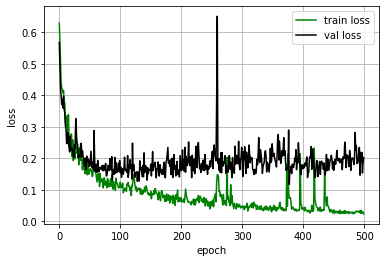

In [ ]:
#显示损失曲线
history = LossHistory()
model.fit_generator(myGene,steps_per_epoch=10,epochs=500,callbacks=[history],validation_data = valid_data, validation_steps = 10) #epoch循环次数
#acc-loss曲线绘制
history.loss_plot('epoch')

In [ ]:
#保存模型
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2105Dinghu/model/M0831_img_150epochs.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=10,epochs=150,callbacks=[model_checkpoint]) #epoch循环次数

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Found 39 images belonging to 1 classes.
Found 39 images belonging to 1 classes.
Epoch 1/150
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 2.0000 - loss: 0.7010 - accuracy: 0.5480
Epoch 00001: loss improved from inf to 0.70097, saving model to /content/drive/MyDrive/2105Dinghu/model/M0831_img_150epochs.hdf5
10/10 [==============================] - 10s 733ms/step - batch: 4.5000 - size: 2.0000 - loss: 0.7010 - accuracy: 0.5480
Epoch 2/150
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 1.9000 - loss: 0.6723 - accuracy: 0.6367
Epoch 00002: loss improved from 0.70097 to 0.67019, saving model to /content/drive/MyDrive/2105Dinghu/model/M0831_img_150epochs.hdf5
10/10 [==============================] - 5s 475ms/step - batch: 4.5000 - size: 1.9000 - loss: 0.6721 - accuracy: 0.6367
Epoch 3/150
10/10 [==============================] - ETA: 0s - batch: 4.5000 - size: 2.0000 - loss: 0.6422 - accuracy: 0.7271
Epoch 00003: loss improved from 0.67019

1/1 [==============================] - 0s 43ms/step
(1, 224, 224, 3)
(1, 224, 224)
(224, 224)
[[0.9499326  0.99549216 0.9978957  ... 0.97610724 0.9836714  0.9139656 ]
 [0.9846599  0.99900335 0.99895877 ... 0.991127   0.98821497 0.95349324]
 [0.9921744  0.9995446  0.9988524  ... 0.9953227  0.9839264  0.9574317 ]
 ...
 [0.9472941  0.9751984  0.96694267 ... 0.99887997 0.99436295 0.9378636 ]
 [0.9524864  0.9849793  0.98936856 ... 0.9954581  0.9694266  0.9109372 ]
 [0.83279705 0.9462267  0.9596163  ... 0.97142744 0.88150096 0.66444063]]


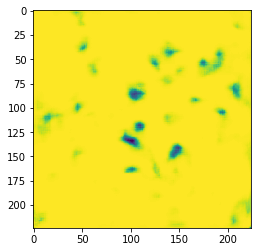

In [ ]:
import matplotlib.pyplot as plt

def testGenerator(test_path,num_image = 30,target_size = (IMG_SIZE,IMG_SIZE),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread('/content/data_0521/test/m_1.tif_0_672.tif')#os.path.join(test_path,"%d.tif"%i),as_gray = as_gray)
        
        img = img / 255
        img = np.expand_dims(img, axis = 0)
        #img = trans.resize(img,target_size)
        #img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        #img = np.reshape(img,(1,)+img.shape)
        yield img

#def labelVisualize(num_class,color_dict,img):
#    img = img[:,:,0] if len(img.shape) == 3 else img
#    img_out = np.zeros(img.shape + (3,))
#    for i in range(num_class):
#        img_out[img == i,:] = color_dict[i]
#    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
#        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.tif"%i),item)



testGene = testGenerator("/content/data_0521/test/")
results = model.predict_generator(testGene,1,verbose=1)
print(results.shape)
conv_t_1 = results[:,:,:,0]
print(conv_t_1.shape)
#print(results.shape)
#saveResult("/content/new_FCN_0422/data",results)
#timg = np.squeeze(results, axis = 3)
#print(timg.shape)
conv_t_1 = np.squeeze(conv_t_1, axis = 0)
print(conv_t_1.shape)
print(conv_t_1)
plt.imshow(conv_t_1 )
#plt.imsave('/content/drive/My Drive/new_FCN_0411/result/m_1.tif_0_672.tif',conv_t_1,cmap='gray')

In [ ]:
import numpy as np 
import os
#import glob
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt

def testGenerator(test_path,num_image = 72,target_size = (224,224),flag_multi_class = False,as_gray = True):
    for img_name in os.listdir(test_path):
        img = io.imread(os.path.join(test_path,"%s"%img_name))#,as_gray = as_gray)
        img = img / 255
        img = np.expand_dims(img, axis=0)
        #img = trans.resize(img,target_size)
        #img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        #img = np.reshape(img,(1,)+img.shape)
        #yield img
        
        results = model.predict(img)
        print(results.shape)
        saveResult("/content/drive/My Drive/new_FCN_0411/result_0610/b/",results,img_name)
        print(img_name)

#def labelVisualize(num_class,color_dict,img):
#    img = img[:,:,0] if len(img.shape) == 3 else img
#    img_out = np.zeros(img.shape + (3,))
#    for i in range(num_class):
#        img_out[img == i,:] = color_dict[i]
#    return img_out / 255

def saveResult(save_path,npyfile,img_name,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        #print(item)
#        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,img_name),item)
        #plt.imsave('/content/drive/My Drive/FCN/plt_img/t%d.tif'%i,item,cmap='gray')
    #timg_1 = np.squeeze(conv_t, axis = 3)
    #print(timg_1.shape)
    #timg_2 = np.squeeze(timg_1, axis = 0)
    #print(timg_2.shape)
    #print(timg_2)
    #plt.imshow(timg_2)
    #plt.imsave('/content/drive/My Drive/FCN/plt_img/t0401_3_test.tif',timg_2,cmap='gray')
  
testGenerator("/content/drive/My Drive/new_FCN_0411/data_0521/test_b/")
#results = model.predict_generator(testGene,72,verbose=1)
#saveResult("/content/drive/My Drive/new_FCN_0411/result_yulin/",results,name)

(1, 224, 224, 3)
b_1.tif_448_0.tif
(1, 224, 224, 3)
b_1.tif_448_224.tif
(1, 224, 224, 3)
b_1.tif_672_224.tif
(1, 224, 224, 3)
b_1.tif_448_448.tif
(1, 224, 224, 3)
b_1.tif_448_672.tif
(1, 224, 224, 3)
b_1.tif_672_0.tif
(1, 224, 224, 3)
b_1.tif_672_448.tif
(1, 224, 224, 3)
b_1.tif_224_224.tif
(1, 224, 224, 3)
b_1.tif_224_448.tif
(1, 224, 224, 3)
b_1.tif_224_672.tif
(1, 224, 224, 3)
b_1.tif_672_672.tif
(1, 224, 224, 3)
b_1.tif_0_224.tif
(1, 224, 224, 3)
b_1.tif_0_672.tif
(1, 224, 224, 3)
b_1.tif_0_448.tif
(1, 224, 224, 3)
b_1.tif_0_0.tif
(1, 224, 224, 3)
b_1.tif_224_0.tif
